# Определение стоимости автомобилей

# Содержание

- [Введение](#intro)
- [Подготовка данных](#data)
- [Предобработка данных](#preprocessing)
  - [Пропуски](#missing)
  - [Дубликаты](#dublicated)
  - [Аномалии](#anomalies)
  - [Удаление ненужных данных](#unnecessary_data)
  - [Изменение типов данных](#types)
  - [Выводы по предобработке данных](#pre_conclusion)
- [Обучение моделей](#fit)
  - [Подготовка данных](#data_preparation)
  - [Линейная Регрессия](#lr)
  - [Древо Решений](#dt)
  - [LightGBM Regressor](#lightgbm)
  - [CatBoost Regressor](#catboost)
  - [Выводы по обучению моделей](#models_conclusion)
- [Анализ моделей](#model_analysis)
  - [Тестирование](#test)
- [Итоговые выводы](#conclusion)

<a id='intro'></a>
## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<a id='data'></a>
## Подготовка данных

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.utils import shuffle

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from ydata_profiling import ProfileReport

**Читаем исходный файл**

In [2]:
try:
    autos = pd.read_csv('autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')
    
original_data = autos

In [3]:
def check_del(df):
    value = df.shape[0] / original_data.shape[0]
    return '{:,.2%}'.format(value)

Данная функция нам понадобится для проверки какой процент данных от изначальных остался после предобработки.

**Основная информация о датафрейме**

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


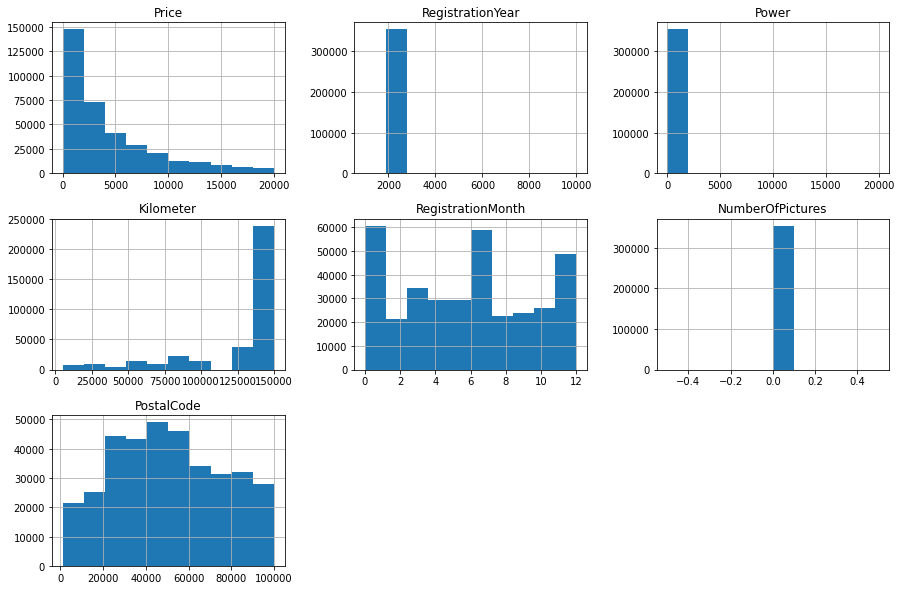

In [6]:
autos.hist(figsize=(15, 10));

Датафрейм содержит 354369 строки (разные автомобили) и 16 стобцов (различные сведения об этих автомобилях). Колонки `DateCrawled`, `DateCreated` и `LastSeen` содержат информацию о датах, но находятся в строковом формате. Мы исправим это на этапе предобработки.

<a id='preprocessing'></a>
## Предобработка данных
<a id='missing'></a>
### Пропуски

Проверим данные на наличие пропусков.

In [7]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Нашли пропуски в 5 колонках: `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`. Рассмотрим каждую из них подробнее.

Начнём с `VehicleType`. Проверим какие значения содержаться в данном столбце.

In [8]:
print('Типы кузовов:', autos['VehicleType'].unique())
print('Количество уникальных значений:', autos['VehicleType'].nunique())

Типы кузовов: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений: 8


`VehicleType` содержит 8 различных типов кузовов. Посмотрим как они распределены.

In [9]:
vt = autos.groupby('VehicleType').agg(total=('VehicleType', 'count'))
display(vt)

,total
VehicleType,
bus,28775
convertible,20203
coupe,16163
other,3288
sedan,91457
small,79831
suv,11996
wagon,65166


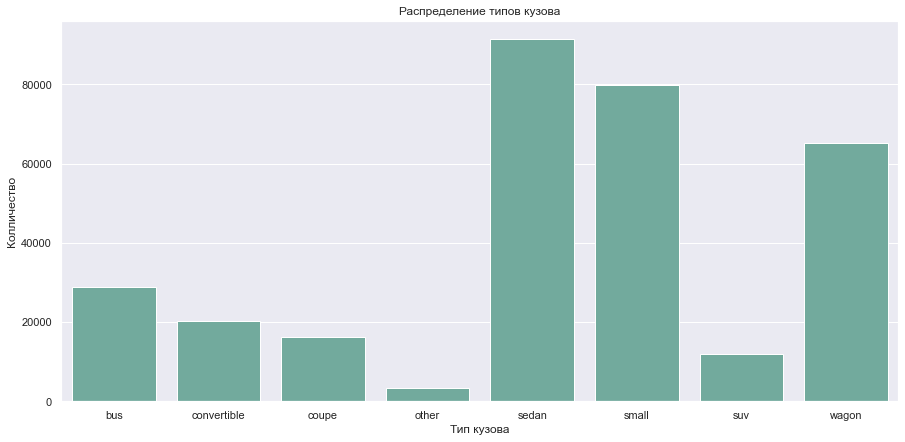

In [10]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x=vt.index, 
    y='total', 
    data=vt, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');
plt.title('Распределение типов кузова');
plt.xlabel('Тип кузова');
plt.ylabel('Колличество');

Три самые рапространённые категории: **wagon** (65166 автомобилей), **small** (79831 автомобилей) и **sedan** (91457 автомобилей), в сумме на них приходится более 65% от общего числа. Пропущенные значения в данной колонке скорей всего связаны с не полным заполнением данных человеком. Так как пропусков слишком много то удалять их мы не будем, вместо этого ввёдём ещё одну категорию unknown (неизвестно) и присовоим её всем пропущенным значениям.

In [11]:
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')

Заполнили пропуски значением 'unknown', посмотрим на количество пропусков теперь.

In [12]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропусков нет в `VehicleType`. Посмотрим как типы кузовов распределены теперь.

In [13]:
vt = autos.groupby('VehicleType').agg(total=('VehicleType', 'count'))
display(vt)

,total
VehicleType,
bus,28775
convertible,20203
coupe,16163
other,3288
sedan,91457
small,79831
suv,11996
unknown,37490
wagon,65166


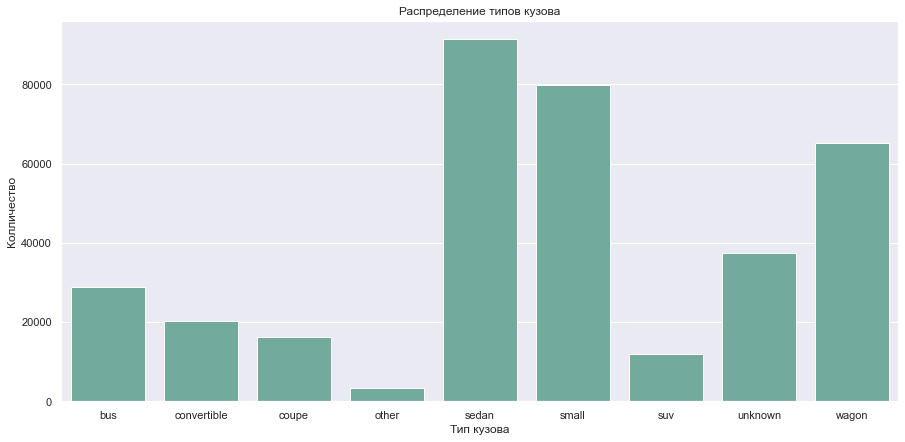

In [14]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x=vt.index, 
    y='total', 
    data=vt, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');
plt.title('Распределение типов кузова');
plt.xlabel('Тип кузова');
plt.ylabel('Колличество');

С пропусками в `VehicleType` закончили, теперь посмотрим на `Gearbox`. 

In [15]:
print('Коробки передач:', autos['Gearbox'].unique())
print('Количество уникальных значений:', autos['Gearbox'].nunique())

Коробки передач: ['manual' 'auto' nan]
Количество уникальных значений: 2


Колонка содержит 2 типа коробок передач. Посмотрим на распределение.

In [16]:
autos.groupby('Gearbox').agg(total=('Gearbox', 'count'))

,total
Gearbox,
auto,66285
manual,268251


manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64


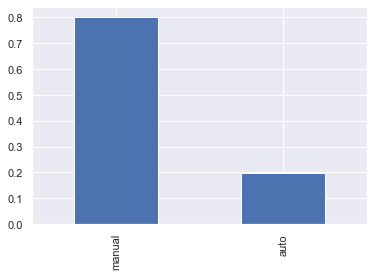

In [17]:
gb_frequency = autos['Gearbox'].value_counts(normalize=True)
print(gb_frequency)
gb_frequency.plot(kind='bar');

80% приходится на manual. Пропущенные значения мы не можем принять за один этих типов. Посмотрим какой процент данных мы потеряем из датасета если удалим данные пропуски.

In [18]:
print('{:,.2%}'.format(autos['Gearbox'].isna().sum() / autos.shape[0]))

5.60%


Мы потеряем 5.6% от изначальных данных. Удалим пропуски.

In [19]:
autos = autos.dropna(subset=['Gearbox']).reset_index(drop=True)

In [20]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                15574
Kilometer                0
RegistrationMonth        0
FuelType             23975
Brand                    0
Repaired             58366
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

После удаления пропусков в `Gearbox`, колличество пропусков в трёх оставшихся с пропусками колонках так же уменьшилось.

Посмотрим на `Model`.

In [21]:
print('Модели:', autos['Model'].sort_values().unique(), '\n')
print('Количество уникальных значений:', autos['Model'].nunique())

Модели: ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'im

In [22]:
models = autos.groupby('Model').agg(total=('Model', 'count')) \
                               .sort_values(by='total', ascending=False)
display(models)

,total
Model,
golf,27757
other,23025
3er,19086
polo,12334
corsa,11791
...,...
i3,7
rangerover,4
serie_3,3


В данных 250 различных моделей. Пропуски можем принять за **other**.

In [23]:
autos['Model'] = autos['Model'].fillna('other')

In [24]:
print('Количество уникальных значений:', autos['Model'].nunique())

Количество уникальных значений: 250


In [25]:
models = autos.groupby('Model').agg(total=('Model', 'count')) \
                               .sort_values(by='total', ascending=False)
display(models)

,total
Model,
other,38599
golf,27757
3er,19086
polo,12334
corsa,11791
...,...
i3,7
rangerover,4
serie_3,3


In [26]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             23975
Brand                    0
Repaired             58366
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Осталось просмотреть на пропуски в `FuelType` и `Repaired`.

In [27]:
print('Типы топлива:', autos['FuelType'].sort_values().unique(), '\n')
print('Количество уникальных значений:', autos['FuelType'].nunique())

Типы топлива: ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan] 

Количество уникальных значений: 7


In [28]:
ft = autos.groupby('FuelType').agg(total=('FuelType', 'count'))
display(ft)

,total
FuelType,
cng,551
electric,78
gasoline,95126
hybrid,227
lpg,5174
other,150
petrol,209255


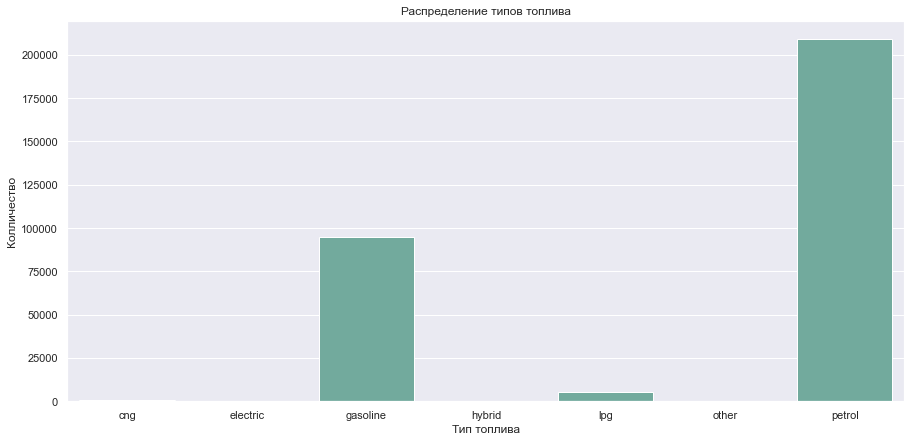

In [29]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x=ft.index, 
    y='total', 
    data=ft, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');
plt.title('Распределение типов топлива');
plt.xlabel('Тип топлива');
plt.ylabel('Колличество');

Пропуски в `FuelType` примем за **other**.

In [33]:
autos['FuelType'] = autos['FuelType'].fillna('other')

In [34]:
ft = autos.groupby('FuelType').agg(total=('FuelType', 'count'))
display(ft)

,total
FuelType,
cng,551
electric,78
gasoline,95126
hybrid,227
lpg,5174
other,24125
petrol,209255


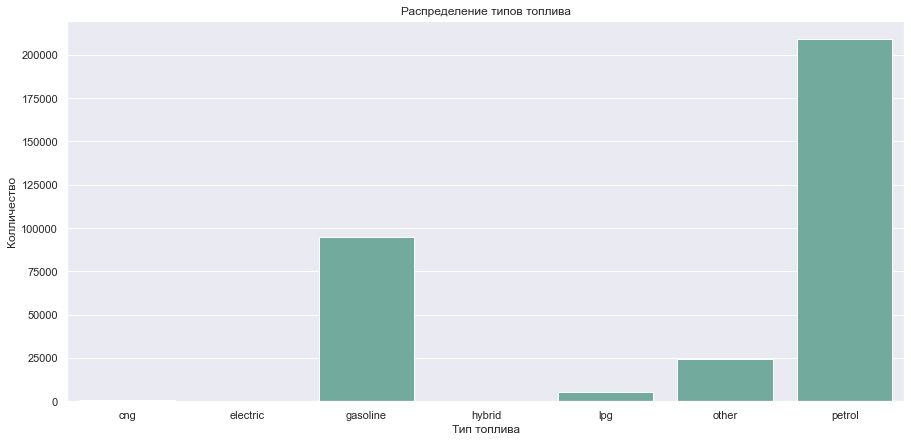

In [35]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x=ft.index, 
    y='total', 
    data=ft, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');
plt.title('Распределение типов топлива');
plt.xlabel('Тип топлива');
plt.ylabel('Колличество');

In [36]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             58366
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Осталась одна колонка с пропусками `Repaired`.

In [37]:
print('Типы топлива:', autos['Repaired'].sort_values().unique(), '\n')
print('Количество уникальных значений:', autos['Repaired'].nunique())

Типы топлива: ['no' 'yes' nan] 

Количество уникальных значений: 2


In [38]:
autos.groupby('Repaired').agg(total=('Repaired', 'count'))

,total
Repaired,
no,241629
yes,34541


no     0.874928
yes    0.125072
Name: Repaired, dtype: float64


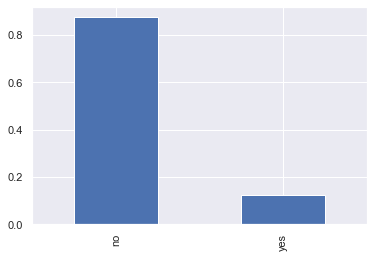

In [39]:
rep_frequency = autos['Repaired'].value_counts(normalize=True)
print(rep_frequency)
rep_frequency.plot(kind='bar');

`Repaired` содержит два типа значений: **no** (87%) и **yes** (13%). Пропусков очень много и заполнение одним из этих значений может исказить конечный результат, поэтому пропускам присвоим значение **unknown**.

In [40]:
autos['Repaired'] = autos['Repaired'].fillna('unknown')

In [41]:
autos.groupby('Repaired').agg(total=('Repaired', 'count'))

,total
Repaired,
no,241629
unknown,58366
yes,34541


no         0.722281
unknown    0.174469
yes        0.103250
Name: Repaired, dtype: float64


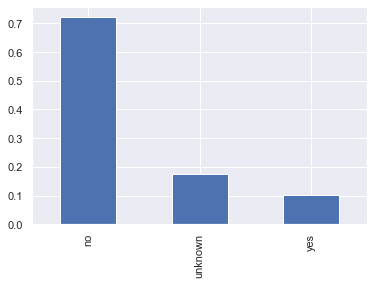

In [42]:
rep_frequency = autos['Repaired'].value_counts(normalize=True)
print(rep_frequency)
rep_frequency.plot(kind='bar');

In [43]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [44]:
check_del(autos)

'94.40%'

**Выводы по работе с пропусками**

Проверили датасет на наличие пропусков. Нашли пропуски в 5 столбцах: `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`.

- В `VehicleType` и `Repaired` пропуски заполнили значением **unknown** тем самым добавив новую категорию.
- Пропуски в `Gearbox` пришлось удалить из-за невозможности их корректно восстановить.
- В `Model` и `FuelType` пропуски приняли за значение **other** которое уже существовало в этих столбцах.

В итоге избавились от пропущенных значений. На данный момент у нас осталось 94.4% от изначальных данных.

In [45]:
report = ProfileReport(autos)

<a id='dublicated'></a>
### Дубликаты

Проверим датасет на наличие дубликатов.

**Явные дубликаты**

In [47]:
autos.duplicated().sum()

4

In [48]:
autos[autos.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
161525,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
218321,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
243688,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
307422,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Нашли 4 явных дубликата, удалим их.

In [49]:
autos = autos.drop_duplicates()

In [50]:
autos.duplicated().sum()

0

Удалили явные дубликаты.

**Неявные дубликаты**

Теперь проверим есть ли неявные дубликаты. Мы уже посмотрели на столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` при работе с пропусками и дубликатов там не было. Осталось посмотреть на столбец `Brand` там могут быть дубликаты из-за ошибок при заполнении анкеты.

In [51]:
print('Бренд:', autos['Brand'].sort_values().unique(), '\n')
print('Количество уникальных значений:', autos['Brand'].nunique())

Бренд: ['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo'] 

Количество уникальных значений: 40


Значения выглядят корректно, дубликатов нет.

**Выводы по работе с дубликатами**

Проверили наличие явных и неявных дубликатов. Нашли 4 явных дубликата и удалили их. 6 столбцов (`VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, `Brand`) потенциально могли содержить неявные дубликаты. Проверив их мы убедились в их отсутсвии.

<a id='anomalies'></a>
### Аномалии

Проверим данные на наличие аномалий.

Начнём с `Price`.

In [52]:
autos['Price'].describe()

count    334532.000000
mean       4547.723279
std        4551.149833
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

В данном стобце не должно быть значений 0. Рассмотрим детальней этот момент.

In [53]:
(autos.query('Price == 0')).shape[0]

8294

In [54]:
autos.query('Price <= 100')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
54,2016-03-29 15:48:15,1,suv,1994,manual,286,other,150000,11,other,sonstige_autos,unknown,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
83,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
102,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
139,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334413,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
334423,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
334450,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32
334479,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09 00:00:00,0,91301,2016-04-06 22:15:32


Нашли 8294 строки с нулями в цене. Так же проверили сколько строк со значениями меньше 100 евро - 10597 строки. Данные значения являются аномалиями, удалим их.

In [55]:
autos = autos.query('Price > 100').reset_index(drop=True)

In [56]:
autos['Price'].describe()

count    323935.000000
mean       4696.121200
std        4549.211482
min         101.000000
25%        1250.000000
50%        2999.000000
75%        6800.000000
max       20000.000000
Name: Price, dtype: float64

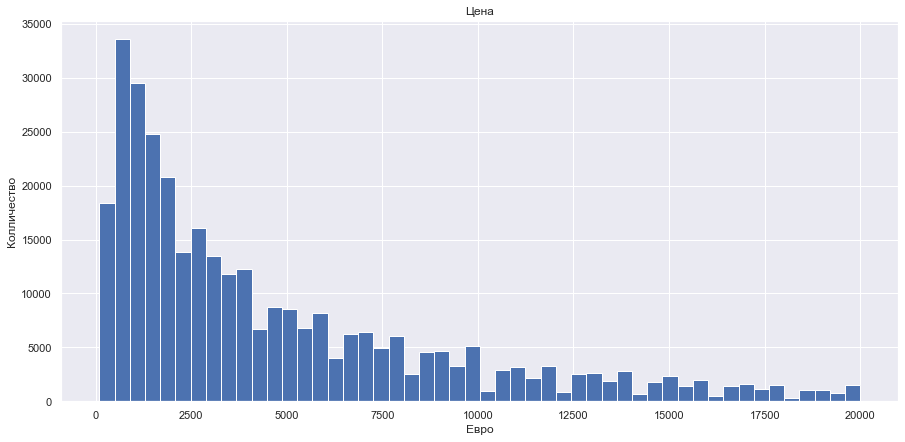

In [57]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist((autos['Price']), bins=50);
ax.set_title('Цена')
ax.set_xlabel('Евро')
ax.set_ylabel('Колличество')
plt.show()

Удалили все строки в которых цена была меньше 100 евро. Посмотрели на распределение цен. Основная часть приходится на диапазон 1000-4000 евро.

Посмотрим на `RegistrationYear`.

In [58]:
autos['RegistrationYear'].describe()

count    323935.000000
mean       2003.419408
std          27.138360
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        8200.000000
Name: RegistrationYear, dtype: float64

В этом стобце точно есть аномалии. Минимальное значении 1000 и максимальное 8200. Год регистрации не может превышать год заполнения анкеты, узнаем дату последней заоплненной анкеты в базе.

In [59]:
pd.to_datetime(autos['DateCreated']).max()

Timestamp('2016-04-07 00:00:00')

Год в `RegistrationYear` не должен превышать 2016.

In [60]:
autos.query('(RegistrationYear < 1980) or (RegistrationYear > 2016)') \
     .sort_values(by='RegistrationYear', ascending=False)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
292938,2016-03-16 07:54:37,500,unknown,8200,auto,81,octavia,10000,11,other,skoda,unknown,2016-03-16 00:00:00,0,30559,2016-03-16 08:52:33
281897,2016-03-25 15:51:10,4000,unknown,7100,manual,0,panda,10000,3,other,fiat,unknown,2016-03-25 00:00:00,0,22115,2016-04-04 18:15:58
42945,2016-03-27 06:01:00,4900,unknown,6000,manual,52,other,10000,0,petrol,sonstige_autos,no,2016-03-27 00:00:00,0,38259,2016-04-07 04:16:10
210481,2016-03-30 20:43:25,2250,unknown,6000,manual,0,other,10000,0,petrol,opel,unknown,2016-03-30 00:00:00,0,6507,2016-04-07 12:45:22
107962,2016-03-27 01:57:32,4900,unknown,6000,manual,52,other,10000,0,petrol,sonstige_autos,no,2016-03-27 00:00:00,0,38259,2016-04-06 22:44:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16671,2016-03-09 17:49:44,7999,unknown,1500,manual,224,impreza,5000,3,other,subaru,unknown,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
254677,2016-03-09 12:43:13,450,unknown,1500,manual,0,other,5000,0,other,volkswagen,yes,2016-03-09 00:00:00,0,26529,2016-04-06 03:15:42
51439,2016-03-30 18:54:27,950,unknown,1400,manual,1400,golf,125000,4,petrol,volkswagen,unknown,2016-03-30 00:00:00,0,50389,2016-04-03 09:45:19
60528,2016-03-08 14:50:20,1300,unknown,1000,auto,0,other,5000,6,petrol,sonstige_autos,unknown,2016-03-08 00:00:00,0,13156,2016-03-17 08:17:42


Проверили сколько строк в данных с годом регистрации до 1980 и после 2016. Нашли 14543 строки, это явные аномалии удалим их.

In [61]:
autos = autos.query('1980 < RegistrationYear < 2016').reset_index(drop=True)

In [62]:
autos['RegistrationYear'].describe()

count    301514.000000
mean       2002.670320
std           5.608798
min        1981.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

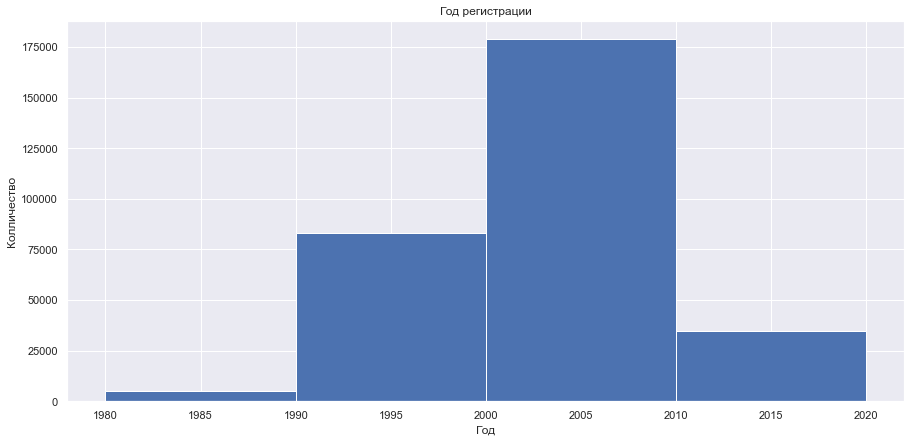

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist((autos['RegistrationYear']), bins=[1980, 1990, 2000, 2010, 2020]);
ax.set_title('Год регистрации')
ax.set_xlabel('Год')
ax.set_ylabel('Колличество')
plt.show()

С аномалиями в `RegistrationYear` закончили.

Посмотрим на столбец `Power`.

In [64]:
autos['Power'].describe()

count    301514.000000
mean        116.923785
std         182.245514
min           0.000000
25%          75.000000
50%         109.000000
75%         146.000000
max       20000.000000
Name: Power, dtype: float64

Как и в `RegistrationYear` видим аномально низкие и аномально высокие значения.

In [65]:
autos.query('Power > 400').sort_values(by='Power', ascending=False)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
186896,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09 00:00:00,0,19406,2016-03-30 08:47:08
254631,2016-03-09 08:53:11,1500,wagon,1997,manual,19312,5er,150000,1,other,bmw,no,2016-03-09 00:00:00,0,21129,2016-04-07 11:44:34
97247,2016-04-03 07:36:21,9999,sedan,2006,manual,19211,1er,125000,0,gasoline,bmw,unknown,2016-04-03 00:00:00,0,45964,2016-04-07 10:16:10
112938,2016-03-25 14:55:49,2100,wagon,2001,manual,19208,5er,150000,5,other,bmw,yes,2016-03-25 00:00:00,0,59556,2016-03-30 05:16:18
54453,2016-03-28 11:49:56,3250,sedan,2001,auto,17932,omega,150000,6,petrol,opel,unknown,2016-03-28 00:00:00,0,86641,2016-04-06 14:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170240,2016-04-01 19:55:01,19500,suv,2008,manual,405,cayenne,150000,2,petrol,porsche,no,2016-04-01 00:00:00,0,85084,2016-04-05 16:45:45
43952,2016-03-19 07:54:59,9199,sedan,1998,manual,401,passat,20000,10,petrol,volkswagen,no,2016-03-19 00:00:00,0,8499,2016-03-31 13:45:52
175908,2016-03-09 03:02:47,14000,suv,2007,auto,401,other,150000,0,petrol,chevrolet,unknown,2016-03-09 00:00:00,0,54290,2016-04-05 12:45:01
15442,2016-03-09 04:03:05,14000,suv,2007,auto,401,other,150000,0,petrol,chevrolet,unknown,2016-03-09 00:00:00,0,54290,2016-04-07 09:16:46


Проверили сколько строк со значением больше 400л.с. Нашли 646 строки, удалим их.

In [66]:
autos =  autos.query('Power < 400').reset_index(drop=True)

In [67]:
autos['Power'].describe()

count    300869.000000
mean        113.267236
std          58.866767
min           0.000000
25%          75.000000
50%         109.000000
75%         145.000000
max         399.000000
Name: Power, dtype: float64

Аномально высокие значения удалили, теперь посмотрим на аномально низкие.

In [68]:
autos.query('Power < 50').sort_values(by='Power', ascending=False)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
154411,2016-03-24 20:46:48,1000,small,2001,manual,49,corsa,150000,2,petrol,opel,unknown,2016-03-24 00:00:00,0,32457,2016-04-01 18:17:21
290554,2016-03-07 11:55:28,555,small,1988,manual,49,fiesta,60000,2,petrol,ford,no,2016-03-07 00:00:00,0,73054,2016-03-08 07:17:25
203712,2016-03-29 11:51:55,160,small,1999,manual,49,ka,150000,10,petrol,ford,no,2016-03-29 00:00:00,0,44319,2016-03-29 11:51:55
57717,2016-03-17 20:57:49,5800,coupe,1981,manual,49,other,10000,1,petrol,skoda,unknown,2016-03-17 00:00:00,0,98693,2016-04-01 14:17:15
278269,2016-04-02 16:45:40,2450,small,2008,manual,49,getz,100000,4,petrol,hyundai,no,2016-04-02 00:00:00,0,24116,2016-04-06 15:45:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109519,2016-03-13 07:37:02,2900,small,2007,auto,0,fortwo,5000,11,other,smart,no,2016-03-13 00:00:00,0,50678,2016-03-20 13:45:59
109488,2016-03-18 22:49:33,750,sedan,2000,manual,0,corsa,150000,2,petrol,opel,no,2016-03-18 00:00:00,0,15848,2016-04-06 02:17:36
109476,2016-03-08 16:48:12,150,sedan,2000,manual,0,focus,150000,1,petrol,ford,unknown,2016-03-08 00:00:00,0,44339,2016-03-15 20:44:24
109459,2016-03-22 20:54:17,1790,convertible,1998,manual,0,golf,150000,6,petrol,volkswagen,no,2016-03-22 00:00:00,0,26831,2016-03-30 02:47:04


In [69]:
(autos.query('Power == 0')).shape[0]

19799

Значения меньше 50л.с мы приняли за аномалии. Нашли 29132 строки, а так же проверили сколько из них с 0л.с - 24286 строки. Изменим все эти значения на медиану (105л.с.).

In [70]:
autos.loc[(autos['Power'] < 50), 'Power'] = autos['Power'].median()

In [71]:
autos['Power'].describe()

count    300869.000000
mean        121.416254
std          49.789337
min          50.000000
25%          87.000000
50%         109.000000
75%         145.000000
max         399.000000
Name: Power, dtype: float64

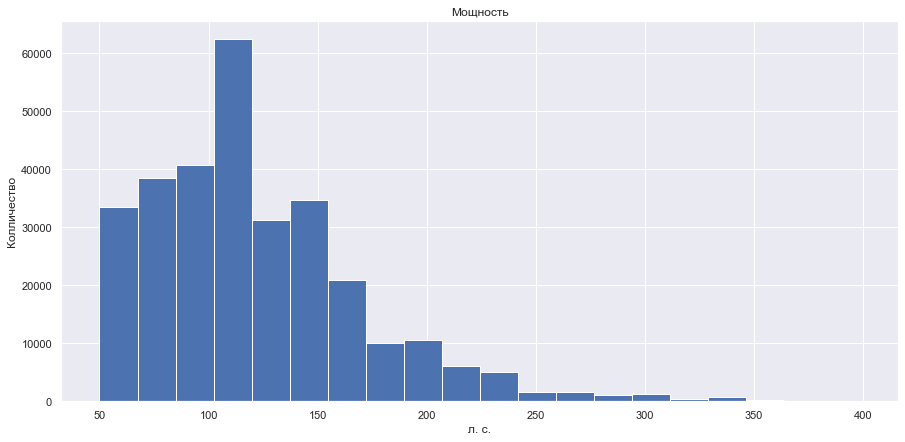

In [72]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist((autos['Power']), bins=20);
ax.set_title('Мощность')
ax.set_xlabel('л. с.')
ax.set_ylabel('Колличество')
plt.show()

C аномалиями в `Power` разобрались. 

Посмотрим на `Kilometer`

In [73]:
autos['Kilometer'].describe()

count    300869.000000
mean     128749.040280
std       36484.491432
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

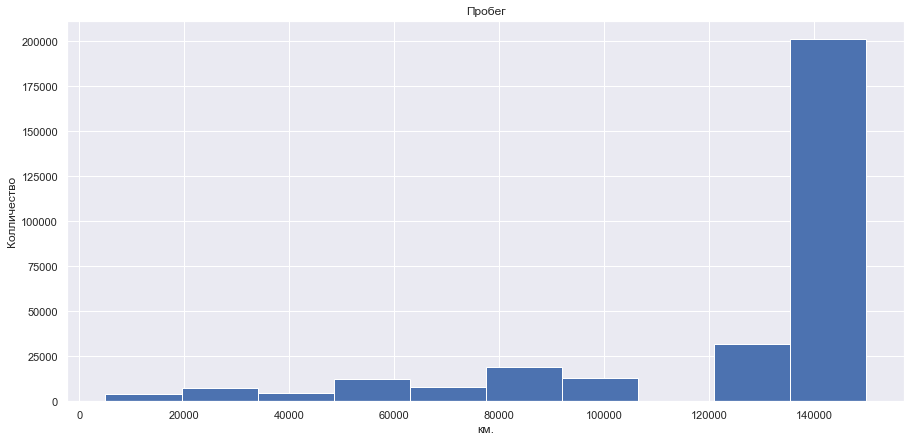

In [74]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist((autos['Kilometer']), bins=10);
ax.set_title('Пробег')
ax.set_xlabel('км.')
ax.set_ylabel('Колличество')
plt.show()

Аномально низких или высоких значений нет. Очень много значений 150000, но учитывая что это б/у автомобили и анкета заполнялась пользователем, то такое значение выглядит логично. Аномалий в `Kilometer` нет.

Проверим `RegistrationMonth`.

In [75]:
autos['RegistrationMonth'].describe()

count    300869.000000
mean          5.972676
std           3.604457
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [76]:
autos['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

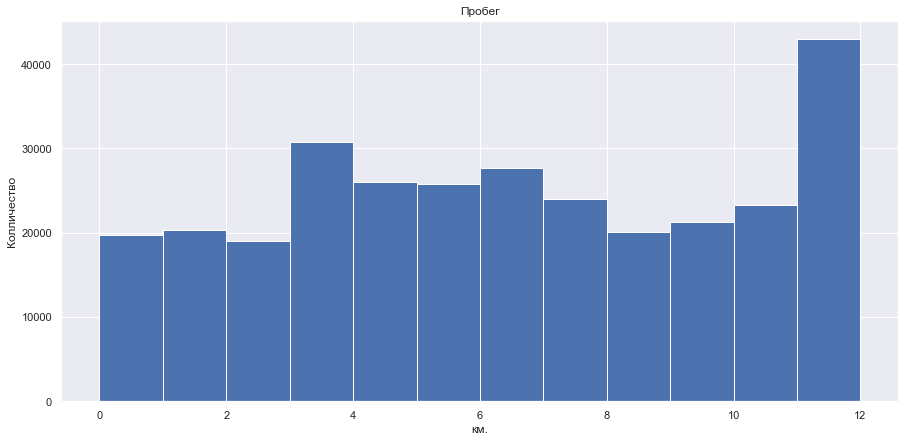

In [77]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist((autos['RegistrationMonth']), bins=np.arange(13));
ax.set_title('Пробег')
ax.set_xlabel('км.')
ax.set_ylabel('Колличество')
plt.show()

Нулевого месяца тут быть не должно, посмотрим сколько таких строк.

In [78]:
(autos.query('RegistrationMonth == 0')).shape[0]

19679

Нашли 24159 строки с нулевым месяцом. Принять за какое-то другое значение мы их не может и удалять их тоже не желательно так как мы потеряем много данных. Данный столбец нам не понадобится для создание моделей, так как он неиформативен для для нахождения цены. Позже на этапе удаление неиформативных признаков удалим его, а пока продолжим работу с аномалиями.

Оставшиеся столбцы мы проверили когда работали с пропусками и дубликатами, кроме `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` которые нам не понадобятся.

In [79]:
autos.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

**Выводы по работе с аномалиями**

Проверили данные на наличе аномалий.

- В столбце `Price` нашли нулевые значения, а так же аномально низкие, удалили эти строки.
- `RegistrationYear` содержал аномальные даты, все строки с годом до 1980 и после 2016 удалили.
- Столбец `Power` содержал как аномально низкие так и высокие значения. Высокие удалили, а низкие (меньше 50л.с.) заменили медианой.
- В `Kilometer` аномалий не обнаружили.
- Со стобцами `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired` мы уже работали на предудущих этапах, аномалии отсутсвуют.
- В `RegistrationMonth` есть аномалии - нулевой месяц которого там быть не должно. Данная колонка содержит признак который нам не понадобится, поэтому пока всё оставили как есть.
- `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` мы не рассматривали, так как они содержат неинформативные признаки и мы их будем удалять.

<a id='unnecessary_data'></a>
### Удаление ненужных данных

`DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` являются неиформативными признаками, удалим их.

In [80]:
autos = autos.drop(['DateCrawled','RegistrationMonth', 'DateCreated',
                    'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1) \
             .reset_index(drop=True)

In [81]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300869 entries, 0 to 300868
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             300869 non-null  int64  
 1   VehicleType       300869 non-null  object 
 2   RegistrationYear  300869 non-null  int64  
 3   Gearbox           300869 non-null  object 
 4   Power             300869 non-null  float64
 5   Model             300869 non-null  object 
 6   Kilometer         300869 non-null  int64  
 7   FuelType          300869 non-null  object 
 8   Brand             300869 non-null  object 
 9   Repaired          300869 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.0+ MB


Удалили ненужные стобцы, теперь у нас осталось 10 колонок.

<a id='types'></a>
### Изменение типов данных

Столбец `Power` имеет вещественный тип, а должен быть в целочисленном, исправим это. Так же для экономии памяти изменим типы `Price` и `RegistrationYear` на *int16* и `Kilometer` на *int32*.

In [82]:
autos['Power'] = autos['Power'].astype('int16')

autos['RegistrationYear'] = autos['RegistrationYear'].astype('int16')
autos['Price'] = autos['Price'].astype('int16')
autos['Kilometer'] = autos['Kilometer'].astype('int32')

In [83]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300869 entries, 0 to 300868
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             300869 non-null  int16 
 1   VehicleType       300869 non-null  object
 2   RegistrationYear  300869 non-null  int16 
 3   Gearbox           300869 non-null  object
 4   Power             300869 non-null  int16 
 5   Model             300869 non-null  object
 6   Kilometer         300869 non-null  int32 
 7   FuelType          300869 non-null  object
 8   Brand             300869 non-null  object
 9   Repaired          300869 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 16.6+ MB


In [84]:
check_del(autos)

'84.90%'

<a id='pre_conclusion'></a>
### Выводы по предобработке данных

Проверили предоставленные данные на наличие пропусков, дубликатов, аномалий:

- Нашли пропуски, часть из них пришлось удалить, в остальных случаях заполнили их наиболее подходящими значениями. После работы с пропусками у нас осталось 94.4% от изначальных данных.
- В данных было только 4 дубликата, удалили их.
- Нашли аномалии в `Price` и `Power`.
 - В стобце с ценой были нулевые значения, а так же незначительное число аномально низких, удалили их.
 - В стобце с мощностью удалили аномально высокие значения (больше 400л.с.), таких значений было относительно немного. А вот аномально низких значений было много, заменили все значения меньше 50л.с. на медиану (105л.с.).

Удалили неиформативные признаки - `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

Изменили типы данных в `Power` с вещественного типа на целочисленный int16, а так же в `Price` и `Kilometer` заменили int64 на int16 и int32 соответсвенно для экономии памяти.

По итогам предобработки у нас осталось 84.90% от изначальных данных.

<a id='fit'></a>
## Обучение моделей

Данные подготовлены, можем переходить к моделям. Обучим 4 вида моделей: Линейная регрессия, Друво решений, LightGBM, CatBoost. Подбор параметров будем производить с помощью кросс-валидации GridSearchCV. Замерим время обучения каждой модели во вермя подбора параметров, а так же результаты метрики качества. В качестве метрики будем использовать RMSE.

<a id='data_preparation'></a>
### Подготовка данных

**Получения выборок**

Нам нужно разделить датасет на две выборки: тренировочную и тестовую. Так как мы будем использовать GridSearchCV, отдельная валидационная нам не понадобится.

Выделим целевой признак - `Price`.

In [85]:
features = autos.drop('Price', axis=1)
target = autos['Price']

Целевой признак выделили, можем делать разбивку. Разделение произведём в соотношении 75%/25%, тренировочная и тестовая выборки соответственно.

In [86]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [87]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(225651, 9)
(75218, 9)
(225651,)
(75218,)


**Прямое кодирование (OHE)**

Подготовим данные для линейной модели. Сделаем прямое кодирование категориальных признаков и масштабирование численных.

In [88]:
categorical = features_train.select_dtypes(include='object').columns.to_list()
numeric = ['RegistrationYear',
           'Power',
           'Kilometer']

ohe_train = features_train.copy()
ohe_test = features_test.copy()

Обозначили категориальные и численные признаки. Создали отдельные переменные для закодированных признаков.

In [89]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_encoder.fit(ohe_train[categorical])

ohe_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_train[categorical])
ohe_train = ohe_train.drop(categorical, axis=1)

C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Обучили кодировщик на категориальных данных из тренировочной выборки. Получили закодированные признаки и удалили из датасета старые категориальные признаки.

In [90]:
ohe_scaler = StandardScaler()
ohe_train[numeric] = ohe_scaler.fit_transform(ohe_train[numeric])

Сделали масштабирование численных признаков тренировочных данных.

In [91]:
ohe_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(ohe_test[categorical])
ohe_test = ohe_test.drop(categorical, axis=1)

ohe_test[numeric] = ohe_scaler.transform(ohe_test[numeric])

C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Обученным на тренировочных данных кодировщиком получили закодированные признаки тестового датасета, а так же масштабировали численные признаки.

**Порядковое кодирование**

Для остальных моделей подготовим данные с помощью порядкового кодирования. Для начала создадим отдельные переменные для признаков.

In [92]:
oe_train = features_train.copy()
oe_test = features_test.copy()

Переменные созданы, произведём кодировние категориальные и маштабирование численных признаков.

In [93]:
oe_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_encoder.fit(oe_train[categorical])

oe_train[oe_encoder.get_feature_names_out()] = oe_encoder.transform(oe_train[categorical])

oe_test[oe_encoder.get_feature_names_out()] = oe_encoder.transform(oe_test[categorical])

In [94]:
oe_scaler = StandardScaler()
oe_train[numeric] = oe_scaler.fit_transform(oe_train[numeric])
oe_test[numeric] = oe_scaler.transform(oe_test[numeric])

Теперь у нас есть три варианта данных для моделей:

- Без кодирования.
- Кодированные техникой One-Hot-Encoding.
- Кодированые техникой Ordinal Encoding.

Приступим к обучению моделей.

<a id='lr'></a>
### Линейная Регрессия

Обучим линейную регресиию используя OHE признаки. Укажем разбивку на 5 блоков для подбора параметров крассвалидацией.

In [95]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {}
lr_model = LinearRegression()

lr_model_cv = GridSearchCV(estimator = lr_model, 
                           param_grid = params, 
                           scoring= 'neg_root_mean_squared_error', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)
lr_model_cv.fit(ohe_train, target_train)
print(lr_model_cv.best_params_, '\n')
print('RMSE on training data: ', lr_model_cv.best_score_, '\n')
print('Среднее время обучения: ', '{:,.3f}'.format(lr_model_cv.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время предсказания: ',  '{:,.3f}'.format(lr_model_cv.cv_results_['mean_score_time'].mean()),'секунд \n')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{} 

RMSE on training data:  -2321.172231947211 

Среднее время обучения:  2.248 секунд
Среднее время предсказания:  0.018 секунд 

CPU times: total: 1min 44s
Wall time: 14.4 s


Обучили модель. Получили **RMSE = 2321**. Среднее время обучения блока **~2.15 секунды**, предсказания - **~0.018 секунды**. В итоге на подбор параметров затрачено **~14 секунд**.

<a id='dt'></a>
### Древо Решений

Обучим древо решиний. Будем использовать Ordinal признаки. Колличество блоков укажем такое же как и для линейной регрессии и для последующих моделей будем так же использовать 5 блоков.

In [96]:
samp_leafs = list(range(1, 16, 2))
samp_split = list(range(2, 13, 2))

print(samp_leafs)
print(samp_split)

[1, 3, 5, 7, 9, 11, 13, 15]
[2, 4, 6, 8, 10, 12]


In [97]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {
          'min_samples_leaf': samp_leafs,
          'min_samples_split': samp_split
         }

dt_model = DecisionTreeRegressor()

dt_model_cv = GridSearchCV(estimator = dt_model, 
                           param_grid = params, 
                           scoring= 'neg_root_mean_squared_error', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True)
dt_model_cv.fit(oe_train, target_train)
print(dt_model_cv.best_params_, '\n')
print('RMSE on training data: ', dt_model_cv.best_score_, '\n')
print('Среднее время обучения: ', '{:,.3f}'.format(dt_model_cv.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время предсказания: ',  '{:,.3f}'.format(dt_model_cv.cv_results_['mean_score_time'].mean()),'секунд \n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'min_samples_leaf': 9, 'min_samples_split': 2} 

RMSE on training data:  -1707.3406733323511 

Среднее время обучения:  0.339 секунд
Среднее время предсказания:  0.009 секунд 

CPU times: total: 1min 31s
Wall time: 1min 31s


Обучили модель. Лучшие параметры **min_samples_leaf: 9, min_samples_split: 2**, удалось достичь **RMSE=1707**, что является намного лучшим результатом чем у линейной регрессии. Среднее время обучения блока **~0.333 секунды**, предсказания - **~0.008 секунды**. На подбор параметров было затрачено **~1минута 30 секунд**.

<a id='lightgbm'></a>
### LightGBM Regressor

До этого мы исполозовали классические модели машинного обучения, сейчас обучим модель градиентного бустинга LightGBM. Попробуем два варианта: обучения на закодированных данных(ordinal) и используя встроенных возможности кодирования LighGBM.

In [98]:
metric = ['rmse']
rate = [0.1]
num_leaves = list(range(30, 160, 40))
est = [1000]
l1 = [0, 1]


print(metric)
print(rate)
print(num_leaves)
print(est)
print(l1)

['rmse']
[0.1]
[30, 70, 110, 150]
[1000]
[0, 1]


In [99]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {
          'metric': metric,
          'learning_rate': rate,
          'num_leaves': num_leaves,
          'n_estimators': est,
          'reg_alpha': l1
         }

lgb_oe_model = lgb.LGBMRegressor()

lgb_oe_model_cv = GridSearchCV(estimator = lgb_oe_model, 
                               param_grid = params, 
                               scoring= 'neg_root_mean_squared_error', 
                               cv = folds, 
                               verbose = 1,
                               return_train_score=True)
lgb_oe_model_cv.fit(oe_train, target_train)
print(lgb_oe_model_cv.best_params_, '\n')
print('RMSE on training data: ', lgb_oe_model_cv.best_score_, '\n')
print('Среднее время обучения: ', '{:,.3f}'.format(lgb_oe_model_cv.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время предсказания: ',  '{:,.3f}'.format(lgb_oe_model_cv.cv_results_['mean_score_time'].mean()),'секунд \n')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 1000, 'num_leaves': 110, 'reg_alpha': 1} 

RMSE on training data:  -1455.4774210484056 

Среднее время обучения:  2.956 секунд
Среднее время предсказания:  0.135 секунд 

CPU times: total: 56min 43s
Wall time: 2min 28s


Обучили модель. Лучшие параметры: **learning_rate': 0.1, n_estimators: 1000, num_leaves: 110, reg_alpha: 1**. Удалось достичь **RMSE=1455**, что является пока лучшим результатом. Среднее время обучения блока **~2.79 секунды**, предсказания - **~0.13 секунды**. На подбор параметров было затрачено **~2 минуты 20 секунд**.

Для использования встроенного кодировщика нам сначала надо поменять тип данных в категориальных столбцах на *category*. Это необходимо для работы втроенного кодирования. Создадим новые переменные и произведём замену.

In [100]:
lgb_train = features_train.copy()
lgb_test = features_test.copy()

In [101]:
for c in lgb_train.columns:
    col_type = lgb_train[c].dtypes
    if col_type == 'object' or col_type.name == 'category':
        lgb_train[c] = lgb_train[c].astype('category')
        
for c in lgb_test.columns:
    col_type = lgb_test[c].dtypes
    if col_type == 'object' or col_type.name == 'category':
        lgb_test[c] = lgb_test[c].astype('category')

In [102]:
lgb_scaler = StandardScaler()
lgb_train[numeric] = lgb_scaler.fit_transform(lgb_train[numeric])
lgb_test[numeric] = lgb_scaler.transform(lgb_test[numeric])

Признаки готовы, можем приступать к подбору параметров.

In [103]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {
          'metric': metric,
          'learning_rate': rate,
          'num_leaves': num_leaves,
          'n_estimators': est,
          'reg_alpha': l1
         }

lgb_model = lgb.LGBMRegressor()

lgb_model_cv = GridSearchCV(estimator = lgb_model, 
                            param_grid = params, 
                            scoring= 'neg_root_mean_squared_error', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)
lgb_model_cv.fit(lgb_train, target_train)
print(lgb_model_cv.best_params_, '\n')
print('RMSE on training data: ', lgb_model_cv.best_score_, '\n')
print('Среднее время обучения: ', '{:,.3f}'.format(lgb_model_cv.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время предсказания: ',  '{:,.3f}'.format(lgb_model_cv.cv_results_['mean_score_time'].mean()),'секунд \n')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'learning_rate': 0.1, 'metric': 'rmse', 'n_estimators': 1000, 'num_leaves': 110, 'reg_alpha': 0} 

RMSE on training data:  -1444.0042678756038 

Среднее время обучения:  3.204 секунд
Среднее время предсказания:  0.162 секунд 

CPU times: total: 1h 3min 10s
Wall time: 2min 43s


Обучили модель. Лучшие параметры: **learning_rate': 0.1, n_estimators: 1000, num_leaves: 110, reg_alpha: 0**. Удалось достичь **RMSE=1443**. Среднее время обучения блока **~3.16 секунды**, предсказания - **~0.16 секунды**. На подбор параметров было затрачено **~2 минуты 45 секунд**.

<a id='catboost'></a>
### CatBoost Regressor

Посмотрим на ещё одну модель градиентного бустинга, CatBoost.

In [104]:
%%time
folds = KFold(n_splits = 5, shuffle = True, random_state = 12345)

params = {'learning_rate': [0.1, 0.2, 0.3, 0.4 , 0.5],
          'verbose': [False],
          'loss_function': ['RMSE']}

cat_model = CatBoostRegressor()

cat_model_cv = GridSearchCV(estimator = cat_model, 
                            param_grid = params, 
                            scoring= 'neg_root_mean_squared_error', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)
cat_model_cv.fit(oe_train, target_train)
print(cat_model_cv.best_params_, '\n')
print('RMSE on training data: ', cat_model_cv.best_score_, '\n')
print('Среднее время обучения: ', '{:,.3f}'.format(cat_model_cv.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время предсказания: ',  '{:,.3f}'.format(cat_model_cv.cv_results_['mean_score_time'].mean()),'секунд \n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'learning_rate': 0.4, 'loss_function': 'RMSE', 'verbose': False} 

RMSE on training data:  -1490.0026467967207 

Среднее время обучения:  8.962 секунд
Среднее время предсказания:  0.007 секунд 

CPU times: total: 1h 5min 49s
Wall time: 3min 55s


Обучили модель. Лучшие параметры: **learning_rate: 0.4**. Удалось достичь **RMSE=1490**. Результат близкий к LightGBM. Среднее время обучения блока **~8.69 секунды**, предсказания - **~0.01 секунды**. На подбор параметров было затрачено **~3 минуты 48 секунд**.

<a id='models_conclusion'></a>
### Выводы по обучению моделей

Обучили 5 моделей, две классичесие и три градиентного бустинга:

- **Линейная регрессия** показала худший результат RMSE, в целом худшие результы.
- **Древо решений** по скорости обучения оказалась на первом месте, RMSE значительно лучше чем у линейной регрессии, но всё же хуже чем у моделей градиентного бустинга.
- **LightBoost** обучили две модели: на данных обработанных техникой порядкового кодирования и встроенным кодировщиком. Обе модели показали лучшие результаты, **RMSE=1455** и **RMSE=1444** соответсвенно, скорость обучения довольно неплохая, а вот предсказания хуже остальных моделей.
- **CatBoost** показал результат хороший результат, **RMSE=1490**, но скорость обучения худшая из 4 моделей, зато предсказания лучшая.

<a id='model_analysis'></a>
## Анализ моделей

Создадим таблицу в которую занесём полученные результаты.

In [105]:
columns = ['Модель',
           'RMSE (евро)',
           'Время подбора параметров (сек)',
           'Время обучения (сек)',
           'Время предсказания (сек)']

results = pd.DataFrame(
                       [
                        ['Линейная регрессия', 2321, 14, 2.18, 0.018],
                        ['Древо решений', 1708, 90, 0.34, 0.008],
                        ['LightGBM (OE)', 1455, 140, 2.79, 0.133],
                        ['LightGBM', 1444, 180, 3.155, 0.158],
                        ['CatBoost', 1490, 232, 8.838, 0.007]
                       ], columns=columns
                      )

display(results)

,Модель,RMSE (евро),Время подбора параметров (сек),Время обучения (сек),Время предсказания (сек)
0,Линейная регрессия,2321,14,2.180,0.018
1,Древо решений,1708,90,0.340,0.008
2,LightGBM (OE),1455,140,2.790,0.133
3,LightGBM,1444,180,3.155,0.158
4,CatBoost,1490,232,8.838,0.007


Если важна скорость предсказания, то CatBoost лучший вариант, но у него скорость обучения худшая из представленых моделей. Остановимся на LightGBM обученной с признаками закодированными техникой порядкового кодирования. Данная модель показала отличные результаты, единственное слабое место - время предсказания.

<a id='test'></a>
### Тестирование

In [106]:
%%time
predictions =  lgb_oe_model_cv.predict(oe_test)
rmse = mean_squared_error(target_test, predictions, squared=False)

print('RMSE =', rmse, '\n')

RMSE = 1434.286778030057 

CPU times: total: 5.86 s
Wall time: 247 ms


Получили **RMSE = 1434** на тестовой выборке, время предсказания ~0.245 секунд. Данный результат нас устраивает.

<a id='conclusion'></a>
## Итоговые выводы

В данном проекте сравнили 4 модели машинного обучения. Нам нужно было предсказать цену б.у. автомобиля, для этого использовали данные о технических характеристиках, комплектации и т.п. различных автомобилей. 

Данные были заполнены пользователями, поэтому их необходимо было обработать. Сделали предобработку, проверили на наличие пропусков, дубликатов, аномалий. Так же скорректировали типы данных в тех колонках где это было необходимо и в тех колонках где удалось таким образом уменьшить объём потребляемой памяти.

После того как очистили данные приступили к подготовки их для моделей. Произвели кодирование техникой One-Hot-Encoding для линейной модели, а так же техникой Ordinal Encoding для остальных. Выделили целевой признак, получили две выборки (тренировочная и тестовая), сделали масштабирование численных признаков. Подобрали лучшие гиперпараметры с помощью кросс-валидации GridSearchCV, сделали замеры времени затраченного на подбор параметров, а так же получили значения метрики качества RMSE на тренировочных данных.

- LightGBM показал лучшие результаты RMSE. Так же отличное время обучения, быстрее только древо решений обучалось. Но время предсказания значительно хуже чем у всех остальных моделей.
- CatBoost по метрике качества RMSE находится на втором месте, не сильно отставая от LightGBM. Но скорость предсказания превосходит остальные модели. Зато время обучения самое низкое.
- Древо решений показало результат существенно хуже чем модели использующщий градиентный бустинг. По скорости обучения в среднем находится между CatBoost и LightGBM. Обучается быстрее чем CatBoost и делает предсказания быстрее чем LigthGBM.
- Линейная регрессия показала худшие результаты.


Можем порекомендовать использовать или LightGBM или Catboost. LightGBM будет лучшим выбором если скорость предсказания не критична, зато если она важна, то CatBoost быстрее всех представленных моделей, а RMSE только немного хуже чем у LighGBM. Если важна скорость обучения, то LighGBM лучший. Древо решений тоже не стоит игнорировать, когда важны обе скорости эта модель показывает неплохие результаты, но метрика качества будет хуже чем у градиентного бустинга, можно сократить разрыв если попробовать больше потратить время на подбор параметров.

В итоге мы выбрали модель LightGBM обученный на признаках обработанных техникой порядкового кодирования. Сделали предсказания на тестовой выборке и получили результаты метрики качества RMSE и время предсказания. **RMSE = 1434** что является хорошим результатом.